# In situ classification of neuron types by semi-supervised deep learning  


### Required modules

In [1]:
# import required modules

import warnings
warnings.filterwarnings('ignore')

import sys
stdout = sys.stdout 

import pickle

from fdc import FDC
# from https://github.com/alexandreday/fast_density_clustering

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import cv2 # OpenCV

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

from matplotlib import colors
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from skimage.io import imsave
from skimage.io import imread

from scipy.stats import gamma

from read_roi import read_roi_file
from read_roi import read_roi_zip
# from https://github.com/hadim/read-roi

from keras.models import load_model

import seaborn.apionly as sns
sns.set_context("poster")
from IPython.display import display

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

/Users/gu6/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


We define some global constant variables:

In [2]:
# get working directory
# raw ISH images are in <DIR>/images
# spreadsheets generated in ImageJ are in <DIR>/spreadsheets
# ImageJ ROI files are in <DIR>/rois
DIR = '.'

# list of raw ISH TIFF files in <DIR>/images that are going to be analyzed
IMG_NAMES = ['20171011-3-sec5','20180213-3-m2-sec8','20180430-3-sec1','20181213-3-m1-sec4']

# list of probes used to cluster data, each cell must have values for these 13 genes
# additional probes can be present in the individual spreadsheets
# probes that are not present in a spreadsheets will be respresented by NaN for the cells from this spreadsheet
PROBELIST = ['cd34', 'mrgprd', 'synpr', 'etv1', 'nppb', 'tmem45b', 'tmem233', 'trpv1', 'calca', 'trpa1', 'trpm8', 's100b', 'fxyd2']

# mapping of cluster names to integers (arbitrary but necessary for compatibility 
# with older UNet models
classes_for_UNet = {'C4':8,'C13':2,'C3':1,'C9':5,'C1':7,'C12':3,'C8':6,'C11':4,'C5':9,'C6':10}

# colors for the different clusters (white is background)
COLORLIST = ['white', 'red','green','magenta','blue','cyan','gold','purple','tan','sienna','darkorange']
color_classes = {k:COLORLIST[v] for k,v in classes_for_UNet.items()}


class_map_inv = {v: k for k, v in classes_for_UNet.items()}


### Representation of marker genes in trigeminal single cell RNA sequencing
  
We load the average expression levels from single cell sequencing in the individual cell clusters exported from RStudio/Seurat and pivot them to generate a heatmap. We then binarize/threshold the heatmap to get a combinatorial code.

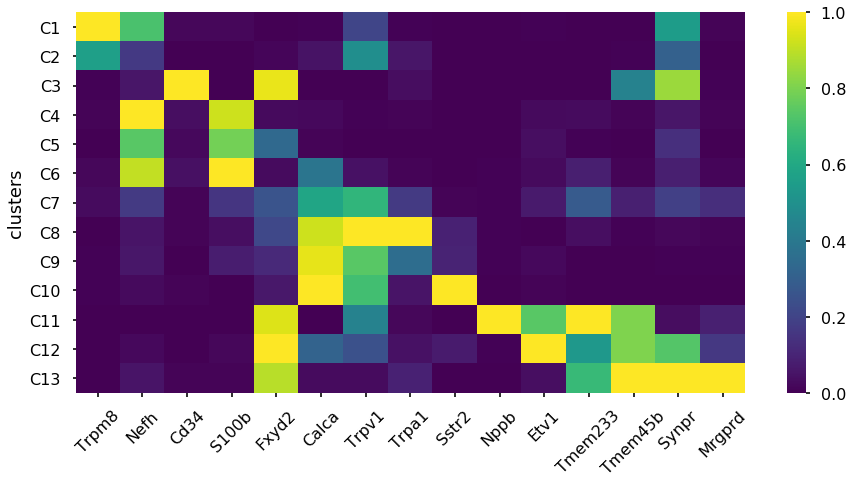

In [3]:
# read single cell cluster/gene table exported from RStudio/Seurat
scseq = pd.read_csv(os.path.join(DIR,'spreadsheets','scseq_heat.csv'),index_col = 0)

# order of clusters and genes
classorder = ['C1' , 'C2' ,'C3' ,'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13']
geneorder = ['Trpm8', 'Nefh', 'Cd34', 'S100b', 'Fxyd2', 'Calca', 'Trpv1', 'Trpa1', 'Sstr2', 'Nppb', 'Etv1', 
             'Tmem233' ,'Tmem45b', 'Synpr', 'Mrgprd']

# pivot the table 
sc_avg_exp = pd.pivot_table(scseq, values='avg.exp.scale', index=['id'], columns=['genes.plot'], aggfunc=np.sum)
sc_avg_exp = sc_avg_exp.loc[classorder,geneorder]

#normalize from 0 to 1
min_ = sc_avg_exp.min(axis=0)
range_ = sc_avg_exp.max(axis=0) - min_
sc_avg_exp_norm = (sc_avg_exp - min_)/range_

#plot heatmap
fig1 = plt.figure(figsize = [15,7])
ax1 = plt.gca()
heatmap1 = sns.heatmap(sc_avg_exp_norm,cmap='viridis')
ax1.xaxis.label.set_visible(False)
plt.xticks(rotation=45)
plt.ylabel('clusters');

# if desired save figure
#plt.savefig('quantitative_code.png',transparent=True)
#plt.savefig('quantitative_code.svg',transparent=True)

We then generate a binary version of this expression map with an arbitrary threshold that best captures the observed patterns.

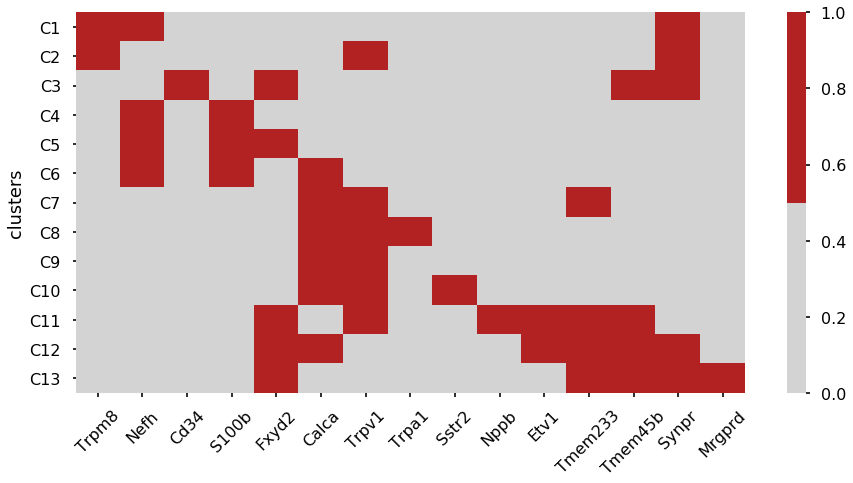

In [4]:
# generate a binary expression map from the heatmap above with a global threshold
sc_bin = sc_avg_exp_norm > 0.27

# manually set trpa1 in C9 to negative to account for gene-specific relative threshold
sc_bin.loc['C9','Trpa1'] = False 

# plot binary heatmap
fig2 = plt.figure(figsize = [15,7])
ax2 = plt.gca()
yellow_on_black = colors.ListedColormap(['lightgrey', 'firebrick'])    
heatmap2 = sns.heatmap(sc_bin,cmap=yellow_on_black)
ax2.xaxis.label.set_visible(False)
plt.xticks(rotation=45)
plt.ylabel('clusters');

# save figures if desired:
# plt.savefig('binary_code.png',transparent=True)
# plt.savefig('binary_code.svg',transparent=True)

## Importing signal intensities from segmented ISH data
  
After reading in signal intensities as spreadsheets that were generated by ROI analysis in ImageJ/Fiji, we subtract background, standardize and reduce dimensionality by tSNE projection.

In [5]:
# function that takes a single spreadsheet with average signal intensities for the 
# individual probes/cells and corresponding background intensity from a ring around
# the cell, generated by an ImageJ script

def import_and_clean(name):
    # the function reads a spreadsheet with mean signal_intensities and returns
    # 1) a dataframe with background subtracted standardized intensities
    # 2) a dataframe with raw standardized intensities
    
    
    
    # read spreadsheet, fill Na's with 0 and lowercase the columns names
    original = pd.read_csv(os.path.join(DIR,'spreadsheets',name + '-results.csv'))
    print("shape of original: ",original.shape)
    original = original.fillna(0)
    original.columns = [x.lower() for x in original.columns]
    
    # pixel to square micrometer conversion
    original['area'] = pow(1/0.721,2) * original.area
    
    # get a copy for the beginning of the results and raw dataframe
    results_frame = original[['roi','area','x','y']].copy()
    
    
    # subtract background from around cells and bottom 10 percentile of intensities
    # (none of the probes is expressed in >90% of cells)
    means = original.filter(regex = r'^mean', axis = 1)
    bg = original.filter(regex=r'^background',axis=1)
    bg_sub = means.as_matrix() - bg.as_matrix()
    means.columns = [s.split('_')[1] for s in means.columns.values]
    bg_sub_frame = pd.DataFrame(bg_sub,columns = means.columns)
    bg_sub_frame = bg_sub_frame  - bg_sub_frame.quantile(0.1,axis=0)
    bg_sub_frame[bg_sub_frame.columns]  = StandardScaler().fit_transform(bg_sub_frame)
    
    # get right order of probes in resultsframe
    results_frame = pd.concat([results_frame,bg_sub_frame],axis=1)
    results_frame.index = results_frame.roi
    results_frame['filename'] = name
    
    # make raw dataframe
    raw_frame = original[['roi','area','x','y']].copy()
    means[means.columns]  = StandardScaler().fit_transform(means)
    raw_frame = pd.concat([raw_frame,means],axis=1)
    raw_frame.index = raw_frame.roi
    
    return results_frame, raw_frame


We read in the data from all 4 mice/images and concatenate them.

In [6]:
# read spreadsheets of all images and concatenate them into 1 background-subtracted 
# (results) and 1 raw dataframe (raw)
result_frames = [None]
raw_frames = [None]
for i,filename in enumerate(IMG_NAMES):
    print("processing file: ",filename)
    result,raw = import_and_clean(filename)
    result_frames.append(result)
    raw_frames.append(raw)
results = pd.concat(result_frames,axis=0)
raw  = pd.concat(raw_frames,axis=0)

processing file:  20171011-3-sec5
shape of original:  (1723, 142)
processing file:  20180213-3-m2-sec8
shape of original:  (2284, 142)
processing file:  20180430-3-sec1
shape of original:  (2135, 142)
processing file:  20181213-3-m1-sec4
shape of original:  (1593, 142)


We calculate coordinates for the tSNE projection of the data.

In [7]:
# generate tSNE projection for only the 13 probes in PROBELIST
tSNE_all = TSNE(n_components=2,random_state=1234).fit_transform(results[PROBELIST])
results['tSNE1'] = tSNE_all[:,0]
results['tSNE2'] = tSNE_all[:,1]

In [8]:
# function to plot tSNE
def plot_tsne(bg_sub_tsne,labels,clusters = [None],cm=None):
    if clusters == [None]:
        clusters = labels.unique()
    if cm is None:
        cm = plt.get_cmap('tab20')
    plt.figure(figsize = [15,12])
    ax = plt.gca()
    for i, c in enumerate(clusters):
        idx = labels == c
        plt.scatter(bg_sub_tsne[idx,0],bg_sub_tsne[idx,1],c=cm(i),label=c,s=50)
    plt.legend(bbox_to_anchor=(1.0, 0.5),loc=3);

We test if the cells from the different images co-cluster nicely.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

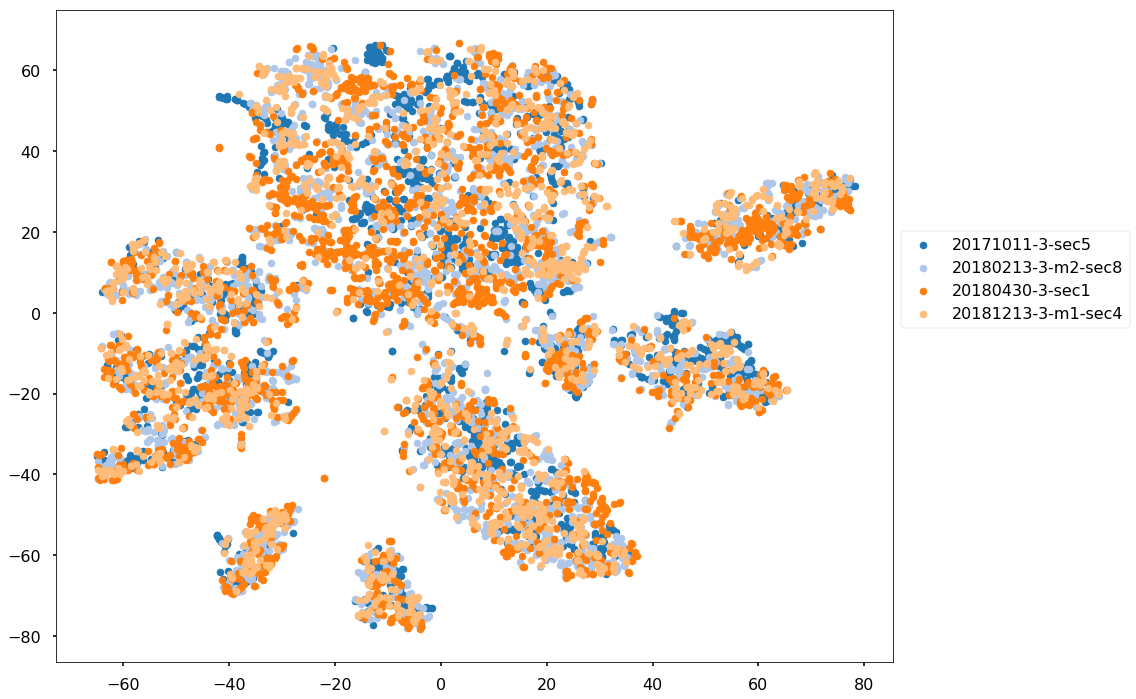

In [9]:
# compare cells from different images in tSNE plot
plot_tsne(results[['tSNE1','tSNE2']].as_matrix(),results['filename'])


No image-specific artefacts are detectable.  


## Unsupervised density-based clustering  
  
We now perform density-based clustering of the tSNE projection according to https://github.com/alexandreday/fast_density_clustering :

In [10]:
#the method messes with standard output so we store and restore it at the end
stdout = sys.stdout 

model = FDC(eta=0.7)
model.fit(tSNE_all)
clusters = model.cluster_label

sys.stdout = stdout

print(np.unique(clusters))
results['cluster'] = clusters

[fdc] nh_size             :   77    
[fdc] eta                 :   0.700 
[fdc] merge               :   True  
[fdc] search_size         :   20    
[fdc] test_size_ratio     :   0.800 
[fdc] Starting clustering with n=7735 samples...
[fdc] Fitting kernel model for density estimation ...
[fdc] Computing density ...
[kde] Minimum bound = 0.4090 	 Rough estimate of h = 2.0452
[kde] Found log-likelihood minima in 9 evaluations, h = 1.91220
[fdc] Computing density ...
[fdc] Finding centers ...
[fdc] Found 48 potential centers ...
[fdc] Merging overlapping minimal clusters ...
      # of stable clusters with noise 0.000000 : 48
[0 1 2 3 4 5 6 7 8 9]


We correlate the unsupervised density-based clusters with known clusters from single cell sequencing based on a simple set of arithmetic rules.

In [11]:
#get average expression of each gene/cluster and normalize from 0 to 1
hcr_avg_exp = results.groupby('cluster',axis=0).mean()
min_ = hcr_avg_exp.min(axis=0)
range_ = hcr_avg_exp.max(axis=0) - min_
hcr_avg_exp_norm = (hcr_avg_exp - min_)/range_

# assign clusters from single cell analysis to HCR clusters based on simple 
# arithmetic rules
C1 = np.argmax(hcr_avg_exp_norm.trpm8) # C1 has highest average trpm8 expression
C3 = np.argmax(hcr_avg_exp_norm.cd34) # C3 has highest average cd34 expression
C4 = np.argmax(hcr_avg_exp_norm.s100b / (hcr_avg_exp_norm.fxyd2 + hcr_avg_exp_norm.calca + 0.1))
# C4 is high in S100b but devoid of Fxyd2 and Calca
C5 = np.argmax(hcr_avg_exp_norm.s100b * hcr_avg_exp_norm.fxyd2) # C5 expresses both S100b and Fxyd2
C6 = np.argmax(hcr_avg_exp_norm.s100b * hcr_avg_exp_norm.calca) # C6 expresses both S100b and Calca
C9 = np.argmax(hcr_avg_exp_norm.trpv1 / (hcr_avg_exp_norm.trpa1 + 0.1)) # C7/9/10 expresses high levels of Trpv1 but no Trpa1
C8 = np.argmax(hcr_avg_exp_norm.trpa1) # C8 has highest Trpa1 expression
C11 = np.argmax(hcr_avg_exp_norm.nppb) # C11 has highest Nppb expression
C12 = np.argmax(hcr_avg_exp_norm.etv1 / (hcr_avg_exp_norm.nppb + 0.1)) # C12 expresses Etv1 but no Nppb
C13 = np.argmax(hcr_avg_exp_norm.mrgprd) # C13 has highest Mrgprd expression
class_map = dict(C1=C1,C3=C3,C4=C4,C5=C5,C6=C6,C8=C8,C9=C9,C11=C11,C12=C12,C13=C13)
class_map_inv = {v: k for k, v in class_map.items()}

results['cluster'] = results.cluster.replace(class_map_inv)
results['UNet'] = results.cluster.replace(classes_for_UNet)
results['cluster'] = pd.Categorical(results['cluster'], ['C1','C3','C4','C5','C6','C8','C9','C11','C12','C13'])
raw['cluster'] = results['cluster']

We display the clusters in the tSNE plot:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

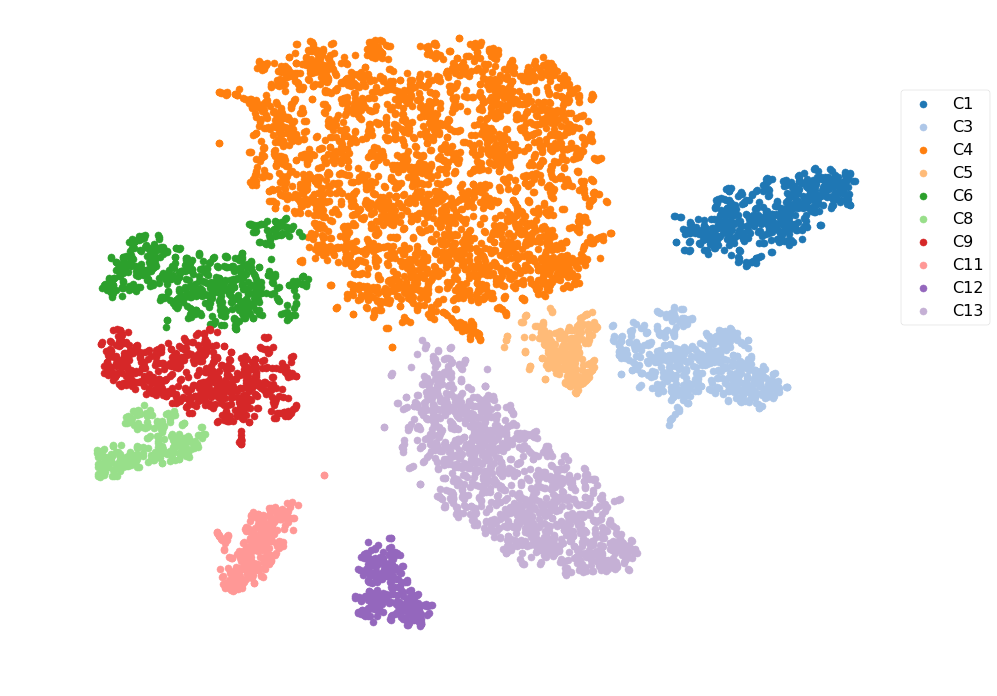

In [12]:
# plot tSNE projection color-coded by cluster identity
plot_tsne(results[['tSNE1','tSNE2']].as_matrix(),results.cluster, clusters = ['C1','C3','C4','C5','C6','C8','C9','C11','C12','C13'])
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor=(1.0, 0.5),loc=3)
plt.axis('off');

## Data Backup

In [13]:
# save background-subtracted and raw results up to this point
results.to_csv(os.path.join(DIR,'spreadsheets','bg_sub_results.csv'), index=False)
raw.to_csv(os.path.join(DIR,'spreadsheets','raw_results.csv'), index = False)

In [14]:
# read results back in from file
results = pd.read_csv(os.path.join(DIR,'spreadsheets','bg_sub_results.csv'))
raw = pd.read_csv(os.path.join(DIR,'spreadsheets','raw_results.csv'))
raw.index = raw.roi
results.index = results.roi
# make cluster categorical for proper sorting
results['cluster'] = pd.Categorical(results['cluster'], ['C1','C3','C4','C5','C6','C8','C9','C11','C12','C13'])
raw['cluster'] = pd.Categorical(raw['cluster'], ['C1','C3','C4','C5','C6','C8','C9','C11','C12','C13'])



## Expression levels of genes in individual cells

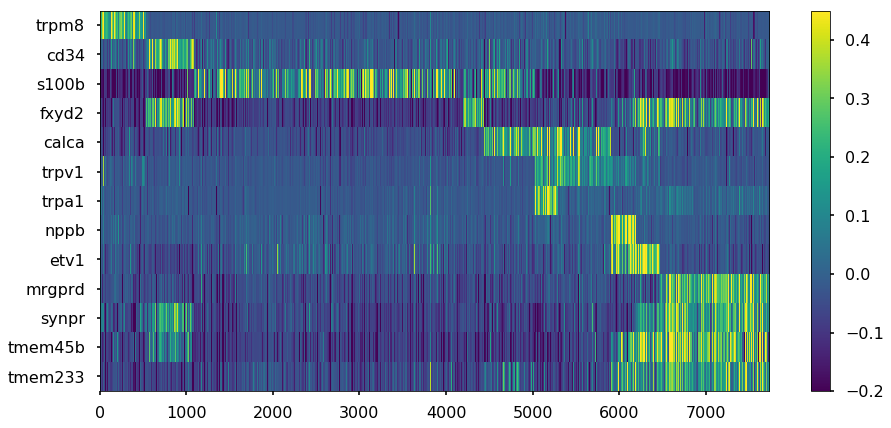

In [15]:
# plot heatmap of individual cells sorted by cluster identity

def plot_heatmap(results,probelist,cmap = 'inferno'):
    n_samples = results.shape[0]
    results_sorted = results.sort_values('cluster')
    
    # sort by probelist
    to_plot = results_sorted[probelist] 
    to_plot = to_plot / to_plot.max(axis=0)
    
    fig3 = plt.figure(figsize = [15,7])
    ax = plt.gca()
    plt.set_cmap(cmap)
    heatmap = plt.imshow(np.clip(to_plot.T,-0.2,0.45),extent=[0,n_samples,0,len(probelist)], aspect='auto') 
    ax.set_yticks([x +0.5 for x in range(len(probelist))])
    ax.set_yticklabels(list(reversed(probelist)));
    ax.grid(False);
    plt.colorbar(heatmap);    


probelist = ['trpm8','cd34','s100b', 'fxyd2', 'calca','trpv1', 'trpa1', 'nppb', 'etv1', 'mrgprd', 'synpr',   'tmem45b', 'tmem233']
plot_heatmap(results,probelist,'viridis')


#plt.savefig('heatmap.png',transparent=True,dpi=300)
#plt.savefig('heatmap.svg',transparent=True)

In [16]:
#function for plotting expression levels of individual genes in tSNE projection

def plot_gene_tSNE (raw,results,probe,clipping=(0,4)):
    probe = probe.lower()
    df = pd.DataFrame({'level':raw[~(raw[probe].isnull())][probe],
            'cluster':results[~(raw[probe].isnull())].cluster,
             'tSNE1': results.tSNE1[~(raw[probe].isnull())],        
             'tSNE2': results.tSNE2[~(raw[probe].isnull())] })
    plt.scatter(df.tSNE1,df.tSNE2,c=np.clip(df.level,clipping[0],clipping[1]),s=5);
    plt.title(probe)
    ax = plt.gca()
    ax.set_facecolor([60/256,60/256,60/256,1])

The same data visualized differently (in the tSNE plot):

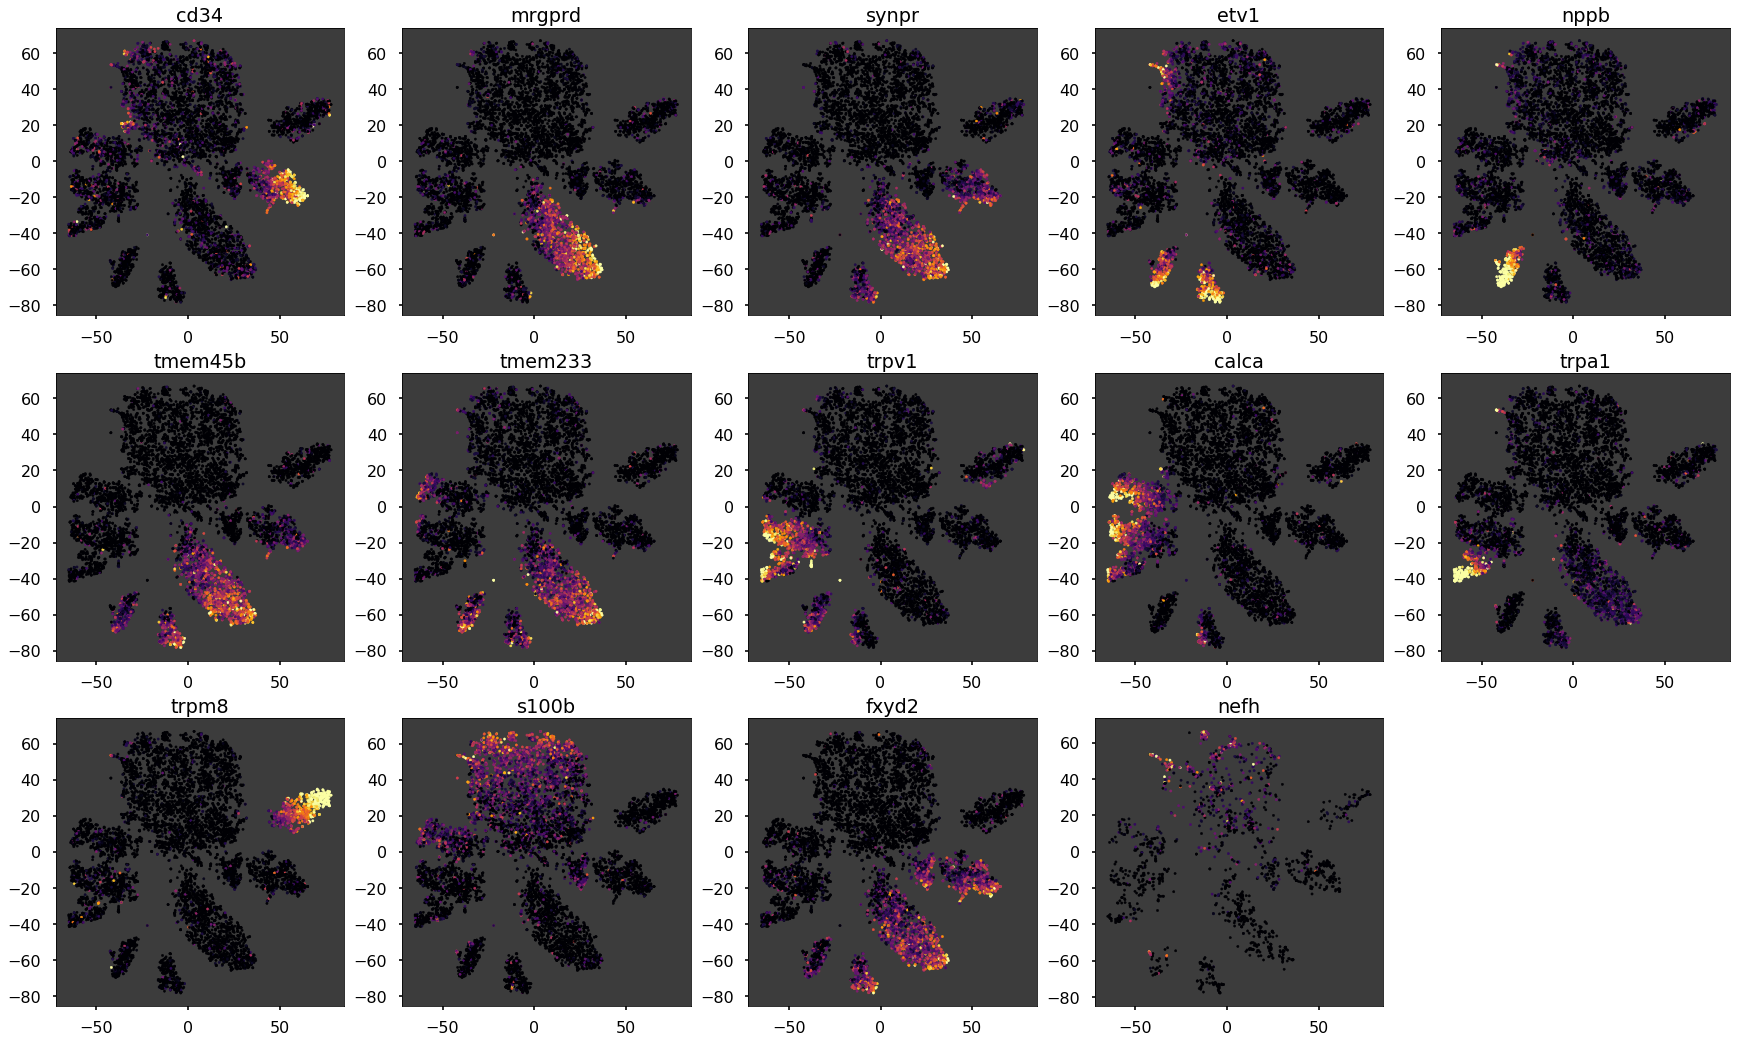

In [17]:
# plot expression tSNE for the 13 relevant probes + nefh
plt.figure(figsize = [30,18])
pl = ['Cd34', 'Mrgprd', 'Synpr', 'Etv1', 'Nppb', 'Tmem45b', 'Tmem233', 'Trpv1', 'Calca', 'Trpa1', 'Trpm8', 'S100b', 'Fxyd2','Nefh']


for i,probe in enumerate(pl):
    
    plt.subplot(3,5,i+1)
    plt.set_cmap("inferno")
    plot_gene_tSNE (raw,results,probe,clipping=(0,4))

# save figure if desired   
# plt.savefig('allprobes-tSNE-2.png')

## Class representation in 4 animals and comparison with single cell sequencing data

First, we show percentages of cell classes in the multiplex ISH analysis
across 4 animals .

In [18]:
clusterlist = ['C1','C3','C4','C5','C6','C8','C9','C11','C12','C13']   

# generate dataframe with mean percentages for each cluster across all animals
fractions = pd.DataFrame({'mean':results.cluster.value_counts()/results.cluster.value_counts().sum()})
name_to_mouse = {'20171011-3-sec5':'FVB/N 1','20180213-3-m2-sec8':'C57BL/6 2',
                 '20180430-3-sec1':'C57BL/6 3','20181213-3-m1-sec4':'C57BL/6 4'}

# group clustered data by animal/filename and calculate percentages for each animal
grouped = results.groupby('filename')
for name,group in grouped:
    name = name_to_mouse[name]
    fractions = fractions.merge(pd.DataFrame({name:group.cluster.value_counts()/group.cluster.value_counts().sum()}),how='outer',left_index=True, right_index=True)

# sort by clusterlist and multiply by 100 for final percentages
fractions = fractions.loc[clusterlist,:] * 100
fractions

# save results if desired
#fractions.to_csv('fractions.csv')


,mean,FVB/N 1,C57BL/6 2,C57BL/6 3,C57BL/6 4
C1,6.839043,4.585026,7.267951,8.290398,6.716886
C3,7.123465,10.737086,6.348511,4.777518,7.470182
C4,40.168067,38.363320,39.711033,44.637002,36.785938
C5,3.154493,3.656413,3.546410,2.622951,2.762084
C6,7.653523,6.906558,8.581436,7.072600,7.909605
C8,3.387201,3.772490,3.239930,3.512881,3.013183
C9,7.899160,7.777133,7.136602,8.430913,8.411802
C11,3.787977,2.553685,4.071804,3.747073,4.770873
C12,3.594053,4.933256,3.415061,2.669789,3.640929
C13,16.393019,16.715032,16.681261,14.238876,18.518519


In [19]:
# manually enter numbers from single cell sequencing
sc_cellnumbers = pd.DataFrame({'numbers':[276+252,442,344,52,167,227+374+354,431,80,68,513]},index=clusterlist)
sc_cellnumbers['fractions'] = sc_cellnumbers.numbers / sc_cellnumbers.numbers.sum() * 100

# sort based on over/under-representation
rel = fractions['mean']/sc_cellnumbers.fractions
fractions= fractions.loc[rel.sort_values().index]
sc_cellnumbers = sc_cellnumbers.loc[rel.sort_values().index]


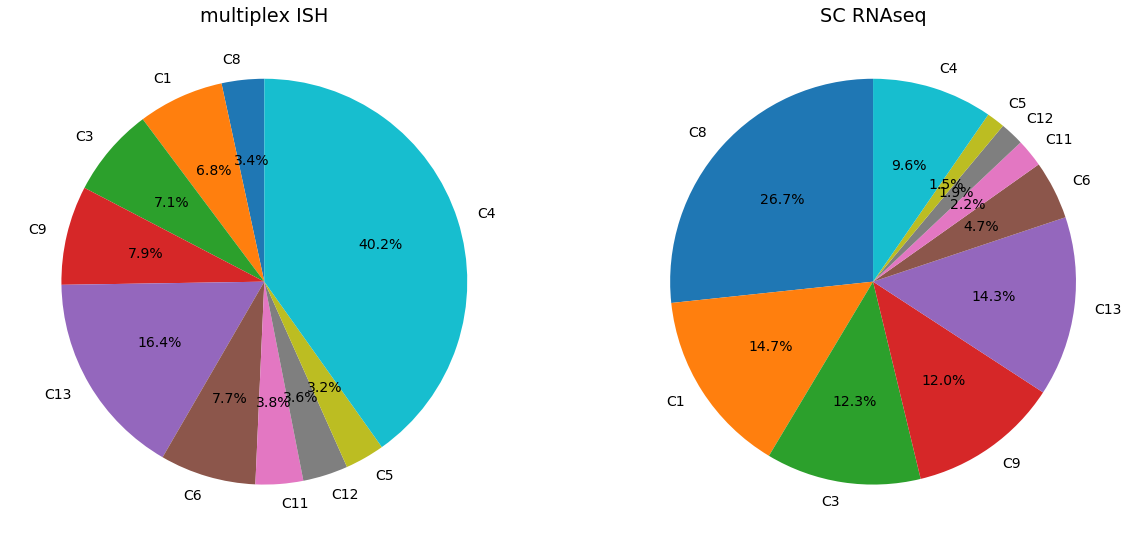

In [20]:
# plot piecharts
plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
ax = plt.gca()
fractions.plot(kind='pie', y = 'mean', autopct='%1.1f%%', ax=ax, title='multiplex ISH',
 startangle=90, shadow=False, labels=fractions.index, legend = False, fontsize=14,cmap='tab10');
plt.ylabel('')
plt.subplot(1,2,2)
ax = plt.gca()
sc_cellnumbers.plot(kind='pie', y = 'fractions', autopct='%1.1f%%', ax=ax,title='SC RNAseq',
 startangle=90, shadow=False, labels=fractions.index, legend = False, fontsize=14,cmap='tab10');
plt.ylabel('');

# save figures if desired
#plt.savefig('piechart-ish.png',transparent=True)
#plt.savefig('piechart-ish.svg',transparent=True)

## Generate multi-hot-encoded masks for the different cell classes  
  
We load the ROIs from the ImageJ-generated zip files and correlate the cluster identity with them. We then draw the ROI to a stack of class masks on the layer corresponding to the correct class. Since we have partially overlapping ROIs/cells this will be a multi-hot-encoded mask. We also generate color-coded images for the spatial distribution of the cells/classes.

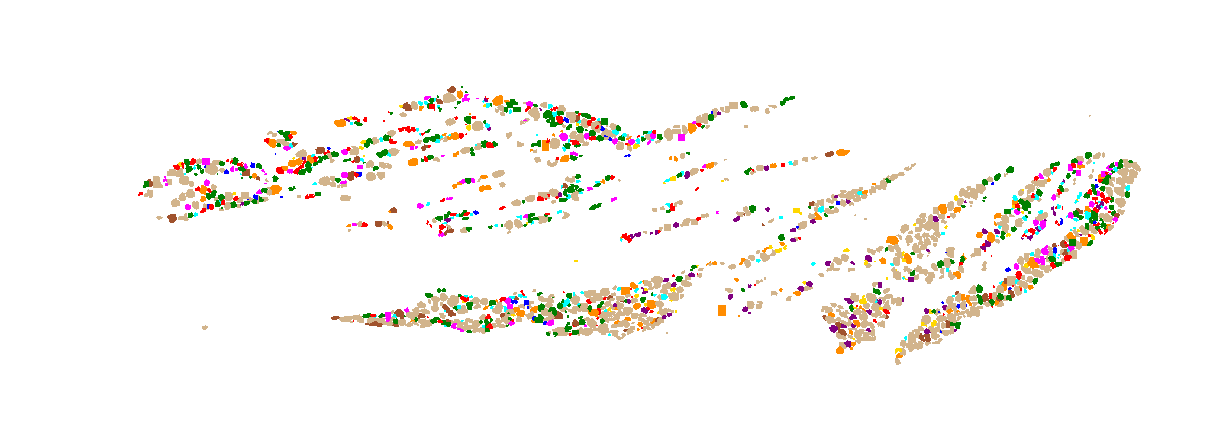

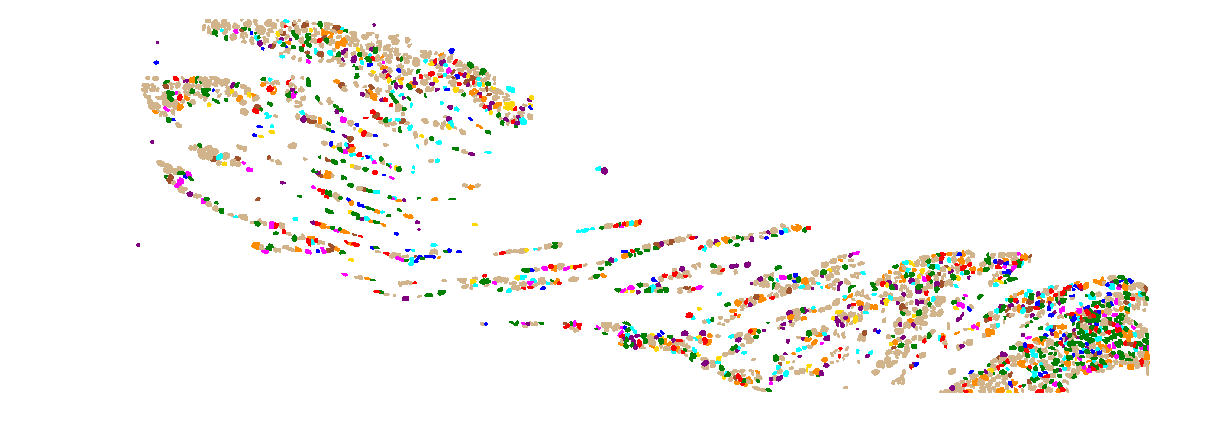

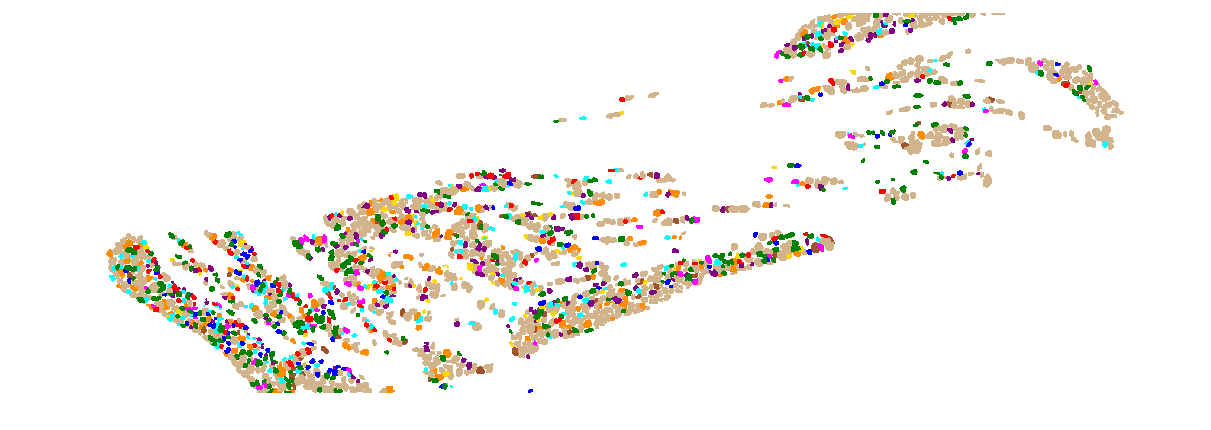

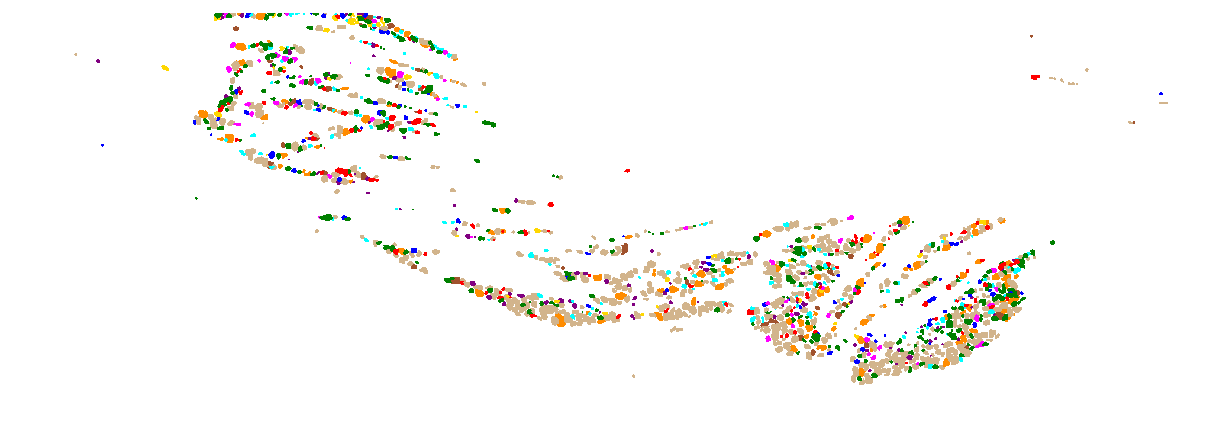

In [21]:
# generate multi-hot masks for individual classes and color-coded images from rois

MASK_SIZE = (1024,3072,11)
masks = []
colormasks = []
# for each original image/filename, generate masks and colormask
grouped_by_img = results.groupby('filename')
for name,group_by_img in grouped_by_img:
    # read rois
    rois = read_roi_zip(os.path.join(DIR,'rois',name + '-rois.zip'))
    
    # generate 3D array of 2D masks (h x w x 11(10 classes + background))
    mask = np.zeros(MASK_SIZE,dtype=np.uint8)
    
    # for each class generate a mask
    grouped_by_class = group_by_img.groupby('UNet')
    for class_, group_by_class in grouped_by_class:
        temp_mask = np.zeros(MASK_SIZE[:2]) # 2D mask for single class
        
        # draw each roi of this class onto mask
        for roi in group_by_class.roi:
            if rois[roi]['type'] == 'traced' or rois[roi]['type'] == 'freehand':
                xs = rois[roi]['x']
                ys = rois[roi]['y']
                pts = np.array(list(zip(xs,ys)))
                pts = pts.reshape((-1,1,2))
                cv2.fillPoly(temp_mask,[pts],True,(1))
            elif rois[roi]['type'] == 'rectangle':
                x1 = rois[roi]['left']
                y1 = rois[roi]['top']
                x2 = x1 + rois[roi]['width']
                y2 = y1 + rois[roi]['height']
                cv2.rectangle(temp_mask,(x1,y1),(x2,y2),(1),cv2.FILLED)
            elif rois[roi]['type'] == 'oval':
                x1 = rois[roi]['left']
                y1 = rois[roi]['top']
                width = rois[roi]['width']
                height = rois[roi]['height']
                centerx = x1 + int(round(width/2))
                centery = y1 + int(round(height/2))
                cv2.ellipse(temp_mask,(centerx,centery), (width,height), 0, 0, 180, (1), cv2.FILLED)

            else:
                print(rois[roi]) # if ROI type is not supported
                
        # write 2D mask into right layer of 3D mask    
        mask[:,:,class_] = temp_mask.astype(np.uint8)
    # layer 0 is the background, i.e. what is left over after all cell classes are assigned
    mask[:,:,0] = 1 - np.max(mask,axis=-1).astype(np.uint8)
    
    # if desired save mask as tiff stack
    #imsave(os.path.join(DIR,'images',name + '-mask.tif'),mask)
    
    # generate a colormask with the specified colorcode
    colormask = np.argmax(mask,axis=-1)    
    cmap = colors.ListedColormap(COLORLIST)    
    sm = matplotlib.cm.ScalarMappable(cmap=cmap)
    rgb = (sm.to_rgba(colormask)[:,:,:3]* 255).astype(np.uint8)
    
    # plot colormask 
    plt.figure(figsize=(21,7))
    plt.imshow(rgb)
    plt.axis('off')
    
    # if desired save the image
    #imsave(os.path.join(DIR,'images',name + '-colormask.tif'),rgb)
    
    # collect everything in a list of arrays
    masks.append(mask)
    colormasks.append(colormask)

## Spatial distribution of C8 cold neurons and C11/C12 itch neurons

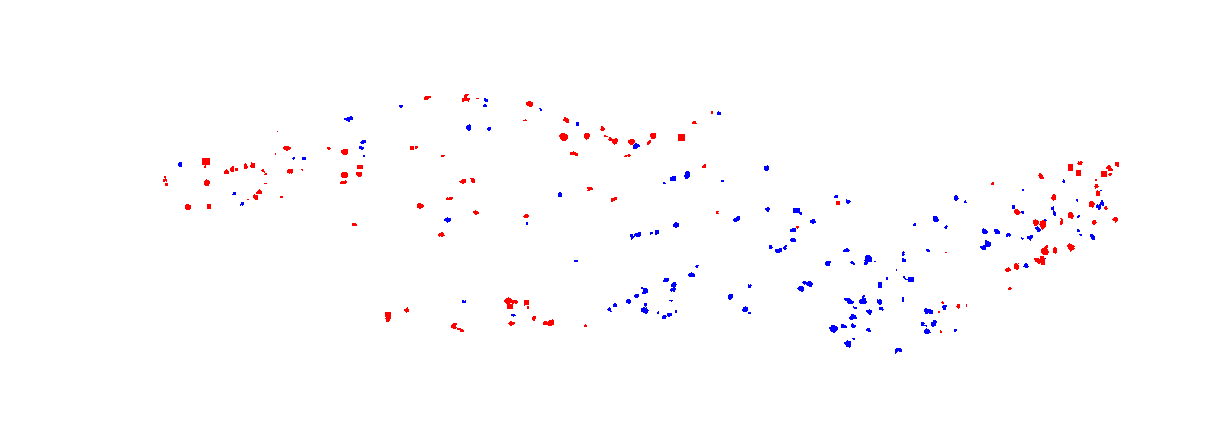

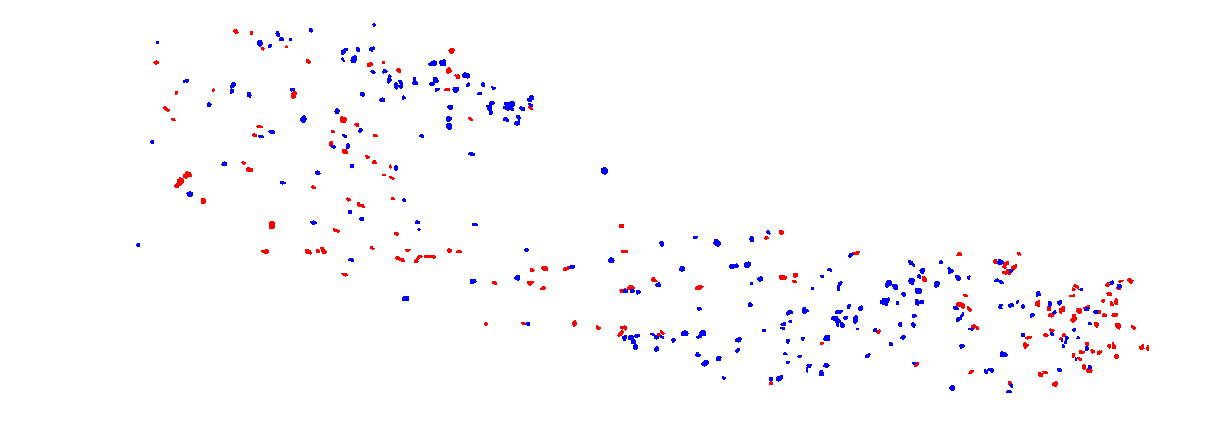

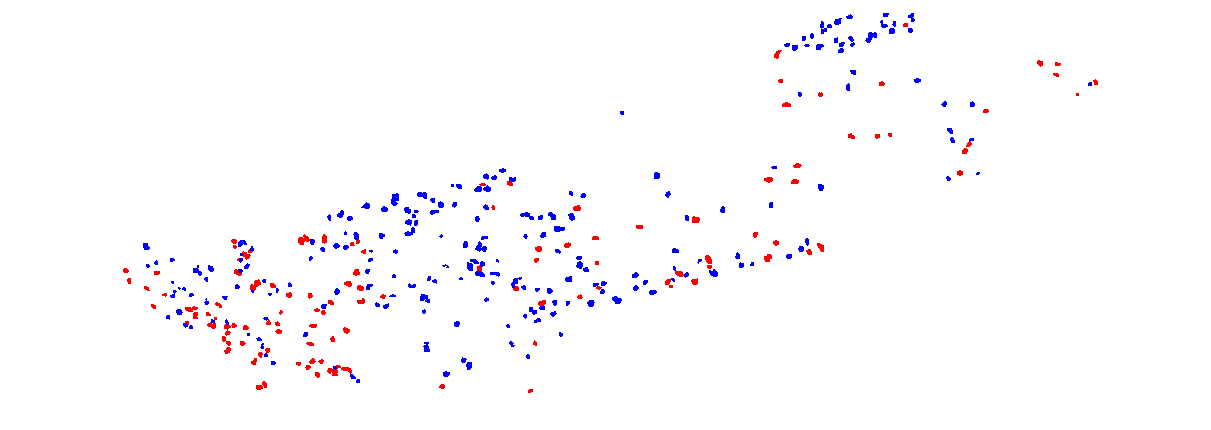

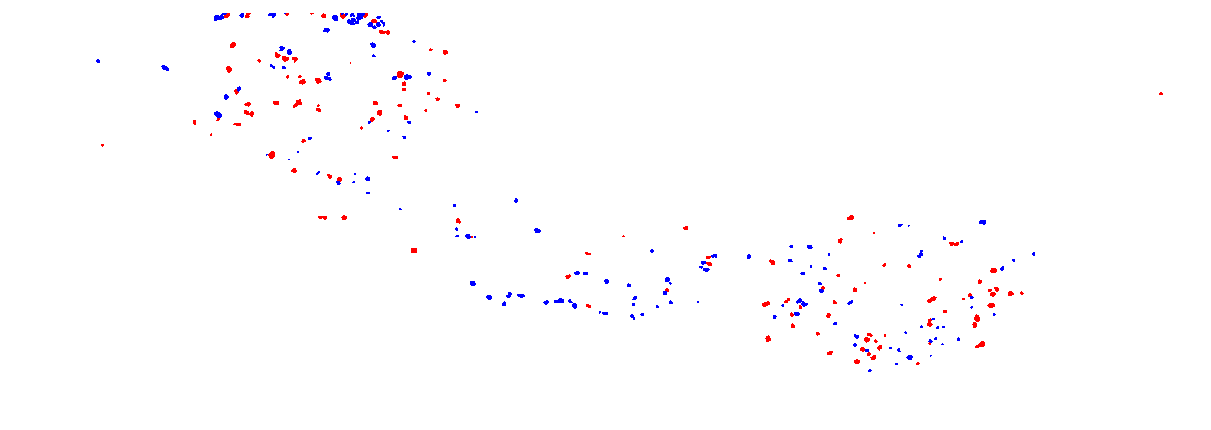

In [22]:
# this is a figure for the paper where we color classes C1 and C8 in blue and classes
# C11 and C12 in red
MASK_SIZE = (1024,3072,3)
# for each group
grouped_by_img = results.groupby('filename')

for name,group_by_img in grouped_by_img:
    rois = read_roi_zip(os.path.join(DIR,'rois',name + '-rois.zip'))
    img = np.ones(MASK_SIZE,dtype=np.uint8) * 255
    itch = group_by_img[np.logical_or(group_by_img.cluster == 'C11',  group_by_img.cluster == 'C12')]
    
    # itch cells in red
    for roi in itch.roi:
        if rois[roi]['type'] == 'traced' or rois[roi]['type'] == 'freehand':
            xs = rois[roi]['x']
            ys = rois[roi]['y']
            pts = np.array(list(zip(xs,ys)))
            pts = pts.reshape((-1,1,2))
            cv2.fillPoly(img,[pts],(255,0,0))
        elif rois[roi]['type'] == 'rectangle':
            x1 = rois[roi]['left']
            y1 = rois[roi]['top']
            x2 = x1 + rois[roi]['width']
            y2 = y1 + rois[roi]['height']
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),cv2.FILLED)
        elif rois[roi]['type'] == 'oval':
            x1 = rois[roi]['left']
            y1 = rois[roi]['top']
            width = rois[roi]['width']
            height = rois[roi]['height']
            centerx = x1 + int(round(width/2))
            centery = y1 + int(round(height/2))
            cv2.ellipse(img,(centerx,centery), (width,height), 0, 0, 180,(255,0,0), cv2.FILLED)

        else:
            print(rois[roi])

    # trp mask
    trp = group_by_img[np.logical_or(group_by_img.cluster == 'C1',  group_by_img.cluster == 'C8')]
    
    for roi in trp.roi:
        if rois[roi]['type'] == 'traced' or rois[roi]['type'] == 'freehand':
            xs = rois[roi]['x']
            ys = rois[roi]['y']
            pts = np.array(list(zip(xs,ys)))
            pts = pts.reshape((-1,1,2))
            cv2.fillPoly(img,[pts],(0,0,255))
        elif rois[roi]['type'] == 'rectangle':
            x1 = rois[roi]['left']
            y1 = rois[roi]['top']
            x2 = x1 + rois[roi]['width']
            y2 = y1 + rois[roi]['height']
            cv2.rectangle(img,(x1,y1),(x2,y2),(0,0,255),cv2.FILLED)
        elif rois[roi]['type'] == 'oval':
            x1 = rois[roi]['left']
            y1 = rois[roi]['top']
            width = rois[roi]['width']
            height = rois[roi]['height']
            centerx = x1 + int(round(width/2))
            centery = y1 + int(round(height/2))
            cv2.ellipse(img,(centerx,centery), (width,height), 0, 0, 180, (0,0,255), cv2.FILLED)

        else:
            print(rois[roi])

    
    plt.figure(figsize=(21,7))
    plt.imshow(img)
    plt.axis('off')
    
    #save as tiff
    #imsave(os.path.join(DIR,'images',name + '-itch-vs-trps.tif'),img)

    

## Generate Training and Validation Data for the fully convolutional U-Net  
  
We tile the large original images into 256 x 256 tiles and designated the left 2/3 of the images as the training set and the right 1/3 as the validation set. This way we can easily perform individual checks on known validation areas of the larger image. Just by looking at the raw data,this separation should not introduce any bias in training vs. validation.


In [23]:
# generate the training and validation folder structure, if not already there
target_dir = os.path.join(DIR,'unet256')

os.makedirs(target_dir)
train_dir = os.path.join(target_dir,"train")
val_dir = os.path.join(target_dir,"val")
os.makedirs(train_dir)
os.makedirs(val_dir)

train_img_dir = os.path.join(train_dir,"images")
train_mask_dir = os.path.join(train_dir,"masks")

val_img_dir = os.path.join(val_dir,"images")
val_mask_dir = os.path.join(val_dir,"masks")

os.makedirs(train_img_dir)
os.makedirs(val_img_dir)
os.makedirs(train_mask_dir)
os.makedirs(val_mask_dir)

In [25]:
# load raw in situ data, ish stacks are channels x height x width
ish_stacks = []
for basename in IMG_NAMES:
    ish_stack = imread(os.path.join(DIR,'images',basename + '.tif'))
    ish_stacks.append(ish_stack)

In [26]:
# (re-)specify folder names
target_dir = os.path.join(DIR,'unet256')
train_dir = os.path.join(target_dir,"train")
val_dir = os.path.join(target_dir,"val")
train_img_dir = os.path.join(train_dir,"images")
train_mask_dir = os.path.join(train_dir,"masks")
val_img_dir = os.path.join(val_dir,"images")
val_mask_dir = os.path.join(val_dir,"masks")
N_CHANNELS = 13

def train_val_prep(image,mask,imagename,imagesize=(256,256)):
    # function to tile and save raw images and corresponding multi-hot masks
    
    # move channels to last axis
    image = np.moveaxis(image,0,-1)
    # only keep the first 13 channels, because only these are consistent in all
    # sections
    image = image[:,:,:N_CHANNELS]
    
    

    # tile image and masks, filter for positive masks, then save
   
    #get x and y positions of the individual tiles
    y_range = [y * imagesize[0] for y in range(np.floor(image.shape[0]//imagesize[0]).astype(np.uint8))]
    
    x_range = [x * imagesize[1] for x in range(np.floor(image.shape[1]/imagesize[1]).astype(np.uint8))]
    
    # divide at 2/3 of width between training and validation data
    breakpoint = np.floor(2*len(x_range)/3).astype(np.uint8)
    x_range_train = x_range[:breakpoint]
    x_range_val = x_range[breakpoint:]
    
    n = 0 #initialize counter for filenames
    for y1 in y_range:
        y2 = y1 + imagesize[0]
        #generate train set
        for x1 in x_range_train:
            x2 = x1 + imagesize[1]
            # crop image and multi-mask then discard all pairs that are all background
            cropped_image = image[y1:y2,x1:x2,:]
            cropped_mask = mask[y1:y2,x1:x2,:]
            
            if np.max(cropped_mask) > 0:
                imsave(os.path.join(train_img_dir,imagename + "-" + str(n) + ".tif" ),cropped_image)
                imsave(os.path.join(train_mask_dir,imagename + "-" + str(n) + ".tif" ),cropped_mask)

                n += 1 # increase file counter
                
        # generate validation set
        for x1 in x_range_val:
            x2 = x1 + imagesize[1]
            # crop image and multi-mask then discard all pairs that are all background
            cropped_image = image[y1:y2,x1:x2,:]
            cropped_mask = mask[y1:y2,x1:x2,:]
            
            if np.max(cropped_mask) > 0:
                # save image
                imsave(os.path.join(val_img_dir,imagename + "-" + str(n) + ".tif" ),cropped_image)
                imsave(os.path.join(val_mask_dir,imagename + "-" + str(n) + ".tif" ),cropped_mask)

                n += 1 # increase file counter

In [27]:
#generate training/validation data for all 4 images
for i,filename in enumerate(IMG_NAMES):
    train_val_prep(ish_stacks[i],masks[i],filename,imagesize=(256,256))

## Setting up training of U-Net fully convolutional nets . 
  
The training of the network was done on the Biowulf supercomputing cluster inside a Singularity container containing all the necessary modules. The container can be pulled from singularity-hub.org with the command  
```bash
singularity pull shub://lars-von-buchholtz/singularity_keras```  
the build specs of the container can be found at https://www.singularity-hub.org/containers/878 and should be transferrable to Docker or any python environment with a Tensorflow-GPU 1.3 installation.

The training code was originally run in a separate jupyter notebook and was copied here. Starter code was adapted from [this kernel](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Datascience Bowl 2018.

Training took ~3h on an NVIDIA Tesla K20 GPU.


In [21]:
# necessary modules
import numpy as np
import pandas as pd
import os
import random

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow, imsave
from skimage.transform import resize

from keras.models import Model, load_model
from keras.layers import Input,Dropout,Conv2D, Conv2DTranspose,MaxPooling2D,Concatenate
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import optimizers

import tensorflow as tf

import pickle

import imgaug


import glob

In [36]:
# defining some global constants
BATCH_SIZE = 16
IMG_WIDTH = 256
IMG_HEIGHT = 256
N_CLASSES = 11

# channel_order of the first 13 channels in the training, validation images
CHANNEL_ORDER = ['cd34','mrgprd','synpr','etv1','nppb','tmem45b','tmem233','trpv1','calca','trpa1','trpm8','s100b','fxyd2']
USE_CHANNELS = CHANNEL_ORDER
TRAIN_PATH = './unet256/train'
VAL_PATH = './unet256/val'
OUT_DIR = './unet256'

We need a few common functions to read, standardize and augment the input data:

In [37]:
from imgaug import augmenters as iaa
def standardize_img(img):
    # function to standardize each image channel to mean 0, standard deviation 1
    img = img.astype(np.float32)
    flat_img = img.reshape(-1, img.shape[-1])
    mean = np.mean(flat_img,axis= 0).reshape((1,1,-1))
    std = np.std(flat_img,axis= 0).reshape((1,1,-1))
    if np.any(std == 0):
        new_img = (img - mean)
    else:
        new_img = (img - mean)/std
    return new_img

# define a standard image augmenter with +-90 degree rotation and flipping along
# both axes
aug = iaa.Sometimes(0.9, [
    iaa.Affine(rotate=(-90, 90),mode='reflect',order = 0),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
])

def load_img_mask(directory, image_id, image_size = (256,256), standardization=False, augmentation=None):
    # function to load,standardize and augment image/mask pair
    
    # Load image and mask
    image = imread(os.path.join(directory,'images',image_id)).astype(np.float32)
    mask = imread(os.path.join(directory,'masks',image_id)).astype(np.float32)
    
    # standardize
    if standardization:
        image = standardize_img(image)
        
    # Augmentation
    # This requires the imgaug lib (https://github.com/aleju/imgaug)
    if augmentation:
        
        # these are methods that are safe to apply to masks
        MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                           "Fliplr", "Flipud", "CropAndPad",
                           "Affine", "PiecewiseAffine"]

        def hook(images, augmenter, parents, default):
            """Determines which augmenters to apply to masks."""
            return (augmenter.__class__.__name__ in MASK_AUGMENTERS)

        # assert that shapes are preserved
        image_shape = image.shape
        mask_shape = mask.shape
        
        # make augmenters deterministic once per image/mask pair to apply same transformation
        det = augmentation.to_deterministic()
        image = det.augment_image(image)
        mask = det.augment_image(mask,hooks=imgaug.HooksImages(activator=hook))
        # assert that shapes are preserved
        assert image.shape == image_shape, "image size was changed"
        assert mask.shape == mask_shape, "mask size was changed"
        
    return image, mask


def data_generator(directory, image_size, shuffle=True, standardization = False, augmentation=None,
                 batch_size=1,channel_order = CHANNEL_ORDER, use_channels = USE_CHANNELS):
    # image data generator that builds on previous function and feeds into 
    # minibatch-driven keras U-Net model
    
    b = 0  # batch item index
    image_index = -1
    
    # get filenames in images and masks with glob
    image_ids = sorted([os.path.basename(x) for x in glob.glob(os.path.join(directory,'images','*tif'))])
    mask_ids = sorted([os.path.basename(x) for x in glob.glob(os.path.join(directory,'masks','*tif'))])
    
    # assert that images and masks have the same filenames
    assert image_ids == mask_ids, "file name discrepancy between images and masks!"
    
    # select subset of channels
    channel_indices = [channel_order.index(i) for i in use_channels]
    
    # generator loop
    while True:
        # Increment index to pick next image. Shuffle if at the start of an epoch.
        image_index = (image_index + 1) % len(image_ids)
        if shuffle and image_index == 0:
            np.random.shuffle(image_ids)

        # Get image and mask
        image_id = image_ids[image_index]
        image, mask = load_img_mask(directory, image_id, image_size, standardization, augmentation)
        # only keep wanted channels
        image = image[:,:,channel_indices]
        # zero-initialize batch arrays
        if b == 0:
            batch_images = np.zeros((batch_size,) + image.shape, dtype=np.float32)
            batch_masks = np.zeros((batch_size, ) + mask.shape, dtype=mask.dtype)

        # add images and masks to batch
        batch_images[b] = image.astype(np.float32)
        batch_masks[b] = mask
        
        # increment batch item counter
        b += 1

        # when current batch is full, yield to generator and start a new batch
        if b >= batch_size:
            yield batch_images,batch_masks
            # initialize counter for new batch
            b = 0
        

In [6]:
# function to build U-Net model
def build_unet(n_filters=[16,32,64,128,256],dropouts=[0.1,0.1,0.2,0.2,0.3],activation='elu',initializer='he_normal',
              optimizer='adam',output='softmax',loss='categorical_crossentropy'):
    # defines a completely symmetric Unet model, feature dimensions of the blocks and dropout rates for the blocks 
    # are defined as lists

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, N_CHANNELS))
    x = inputs
    shortcuts = []
    
    # first half of the Unet, each block has 2 convolutional layers, separated by a dropout layer and followed
    # by a maxpooling layer
    # the output of the second conv layer is saved in shortcuts to feed into the second half of the Unet
    for i, filter_size in enumerate(n_filters[:-1]):
        x = Conv2D(filter_size, (3, 3), activation=activation, kernel_initializer=initializer, padding='same') (x)
        x = Dropout(dropouts[i]) (x)
        x = Conv2D(filter_size, (3, 3), activation=activation, kernel_initializer=initializer, padding='same') (x)
        shortcuts.append(x)
        x = MaxPooling2D((2, 2)) (x)

    # middle layer
    x = Conv2D(n_filters[-1], (3, 3), activation=activation, kernel_initializer=initializer, padding='same') (x)
    x = Dropout(dropouts[-1]) (x)
    x = Conv2D(n_filters[-1], (3, 3), activation=activation, kernel_initializer=initializer, padding='same') (x)

    # second half of the Unet = the reverse ConvNet 
    # in each block, the previous layer is upsampled by an inverse convolution, then concatenated with the 
    # corresponding layer of the first half of the Unet
    # then follow 2 convolutional layers separated by a dropout layer
    for i in range(len(shortcuts)-1,-1,-1):
        x = Conv2DTranspose(n_filters[i], (2, 2), strides=(2, 2), padding='same') (x)
        x = Concatenate()([x, shortcuts[i]])
        x = Conv2D(n_filters[i], (3, 3), activation=activation, kernel_initializer=initializer, padding='same') (x)
        x = Dropout(dropouts[i]) (x)
        x = Conv2D(n_filters[i], (3, 3), activation=activation, kernel_initializer=initializer, padding='same') (x)
    
    # for the output we convolve the last layer to arrive at a single channel representing the probability
    # of each pixel for being foreground
    outputs = Conv2D(N_CLASSES, (1, 1), activation=output) (x)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optimizer, loss=loss)
    model.summary()
    return model

## Training a 13 channel input U-Net

In [ ]:
# define channels 
USE_CHANNELS = CHANNEL_ORDER # use in exactly this order for the 13 channel model

# define training and validation generators (validation data is not shuffled or augmented)
train_gen = data_generator(TRAIN_PATH, image_size = (256,256), shuffle=True, standardization = True, augmentation=aug,
                 batch_size=BATCH_SIZE,channel_order = CHANNEL_ORDER, use_channels = USE_CHANNELS)
val_gen = data_generator(VAL_PATH, image_size = (256,256), shuffle=False, standardization = True, augmentation=None,
                 batch_size=BATCH_SIZE,channel_order = CHANNEL_ORDER, use_channels = USE_CHANNELS)

Initially, we experimented with different numbers of convolutional blocks, final activation functions, loss functions, learning rate, data augmentation and dropout. The following network performed best on the validation data. We use early stopping to finish training when the validation loss no longer improves.

In [18]:
# Model 5: this is the model with the optimal architecture and hyperparameters in
# our exploration
adam_optimizer = optimizers.Adam(lr=0.0005)
unetmodel5 = build_unet(optimizer=adam_optimizer,output='softmax',loss='categorical_crossentropy')

earlystopper = EarlyStopping(patience=10, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join(OUT_DIR,'Graph5'), histogram_freq=0, write_graph=True, write_images=True)
checkpointer = ModelCheckpoint(os.path.join(OUT_DIR,'unetmodel5_13channel.h5'), verbose=1, save_best_only=True)

results = unetmodel5.fit_generator(train_gen, steps_per_epoch = steps_per_epoch, epochs=200, 
                    callbacks=[earlystopper, checkpointer,tensorboard], validation_data = val_gen,
                    validation_steps = validation_steps)

model5_metrics = results.history

Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 13)  0                                            
____________________________________________________________________________________________________
conv2d_20 (Conv2D)               (None, 256, 256, 16)  1888        input_2[0][0]                    
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, 256, 256, 16)  0           conv2d_20[0][0]                  
____________________________________________________________________________________________________
conv2d_21 (Conv2D)               (None, 256, 256, 16)  2320        dropout_10[0][0]                 
__________________

In [19]:
# save learning history and reload it
with open(os.path.join(OUT_DIR,'unetmodel5_history.pkl'),'wb') as f:
    pickle.dump(results.history,f)
    
with open(os.path.join(OUT_DIR,'unetmodel5_history.pkl'),'rb') as f:
    model5_metrics = pickle.load(f)

### Learning curve of model

Text(0,0.5,'binary crossentropy loss')

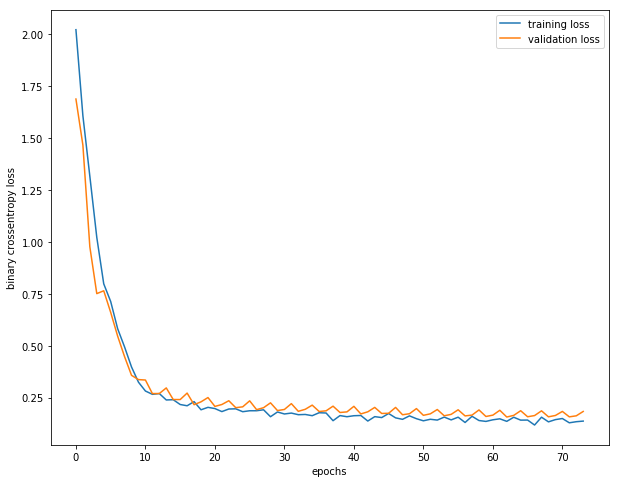

In [17]:
plt.figure(figsize=[10,8])
ax = plt.gca()
plt.plot(model5_metrics['loss'])
plt.plot(model5_metrics['val_loss']);
plt.legend(['training loss','validation loss']);
plt.xlabel('epochs')
plt.ylabel('binary crossentropy loss');


## Training a 8 channel input U-Net  
  
Based on the combinatorial expression patterns in the desired cell classes, we reasoned that the following 8 channels should be sufficient to assign class identity.

In [66]:
# define channels for  8 channel model:
USE_CHANNELS = ['mrgprd','nppb','tmem233','calca','trpa1','trpm8','s100b','fxyd2']
N_CHANNELS = len(USE_CHANNELS)

In [ ]:
# define training and validation generators (validation data is not shuffled or augmented)
train_gen = data_generator(TRAIN_PATH, image_size = (256,256), shuffle=True, standardization = True, augmentation=aug,
                 batch_size=BATCH_SIZE,channel_order = CHANNEL_ORDER, use_channels = USE_CHANNELS)
val_gen = data_generator(VAL_PATH, image_size = (256,256), shuffle=False, standardization = True, augmentation=None,
                 batch_size=BATCH_SIZE,channel_order = CHANNEL_ORDER, use_channels = USE_CHANNELS)

Architecture and hyperparameters are the same as for the 13 channel model.

In [7]:
adam_optimizer = optimizers.Adam(lr=0.0005)
unetmodel5 = build_unet(optimizer=adam_optimizer,output='softmax',loss='categorical_crossentropy')

earlystopper = EarlyStopping(patience=10, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join(OUT_DIR,'Graph5'), histogram_freq=0, write_graph=True, write_images=True)
checkpointer = ModelCheckpoint(os.path.join(OUT_DIR,'unetmodel5_8channel.h5'), verbose=1, save_best_only=True)

results = unetmodel5.fit_generator(train_gen, steps_per_epoch = steps_per_epoch, epochs=200, 
                    callbacks=[earlystopper, checkpointer,tensorboard], validation_data = val_gen,
                    validation_steps = validation_steps)

model5_8chan_metrics = results.history

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 8)   0                                            
____________________________________________________________________________________________________
conv2d_20 (Conv2D)               (None, 256, 256, 16)  1168        input_2[0][0]                    
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, 256, 256, 16)  0           conv2d_20[0][0]                  
____________________________________________________________________________________________________
conv2d_21 (Conv2D)               (None, 256, 256, 16)  2320        dropout_10[0][0]                 
___________________________________________________________________________________________

## Predicting the complete, large images with our 2 models

In [30]:
def tile_and_predict(model,image,size=(256,256),overlap = 64):
    # this function tiles our large image into 256 x 256 tiles with considerable overlap, because
    # we assume that predictions at the borders of tiles might be less reliable
    # we then predict with the model and combine the predicted tiles to a larger 
    # composite prediction
    # returns a height x width x N_CLASSES + 1 array with the probabilities of that
    # pixel being of a certain class
    
    
    assert overlap %2 == 0,'overlap has to be even!'
    
    # function to tile horizontally, returns list of tiles and list of x positions
    def tile_horizontal(image,size,overlap):

        n_tiles = (image.shape[1]-overlap)//(size[1]-overlap)
        tiles = []
        x_pos = []
        end = 0
        for i in range(n_tiles):
            start = i*(size[1]-overlap)
            x_pos.append(start)
            end = start+size[1]
            tiles.append(image[:,start:end,:])
        if end<image.shape[1]:
            start = image.shape[1]-size[1]
            x_pos.append(start)
            end = image.shape[1]
            tiles.append(image[:,start:end,:])
        return tiles, x_pos
    
    # function to tile vertically, returns list of tiles and list of y positions
    def tile_vertical(image,size,overlap):

        n_tiles = (image.shape[0]-overlap)//(size[0]-overlap)
        tiles = []
        y_pos = []
        end = 0
        for i in range(n_tiles):
            start = i*(size[0]-overlap)
            y_pos.append(start)
            end = start+size[0]
            tiles.append(image[start:end,:,:])
        if end<image.shape[0]:
            start = image.shape[0]-size[0]
            y_pos.append(start)
            end = image.shape[0]
            tiles.append(image[start:end,:,:])
        return tiles, y_pos

    # combine horizontal and vertical tiling, returns 3 lists: tiles, x pos and y pos
    def tile_2d(image,size,overlap):
        tiles = []
        y_tiles, y_pos = tile_vertical(image,size,overlap)
        for i in range(len(y_pos)):
            x_tiles, x_pos = tile_horizontal(y_tiles[i],size,overlap)
            x_tiles = np.stack(x_tiles, axis=0)
            tiles.append(x_tiles)
        tiles = np.stack(tiles, axis=0)

        #tiles is a y_pos x x_pos x height x width x channels array
        return tiles,y_pos,x_pos
    
    # stitching things back together in x
    def stitch_horizontal(x_tiles,x_pos):
        height = x_tiles[0].shape[0]
        tile_width= x_tiles[-1].shape[1]
        width = x_pos[-1]  + tile_width
        n_channels = x_tiles[0].shape[2]
        image = np.zeros([height,width,n_channels])

        # all but the last tile are defined width
        end = 0
        for i in range(len(x_pos)-1):
            start = end
            tile_start = start - x_pos[i]
            end = (start + tile_width + x_pos[i+1])//2
            tile_end = end - x_pos[i]
            image[:,start:end,:]=x_tiles[i,:,tile_start:tile_end,:]

        #last tile is the leftover width
        start = end
        tile_start = start - x_pos[-1]
        end = width
        image[:,start:end,:]=x_tiles[-1,:,tile_start:,:]
        return image
    
    # stitching things back together in y
    def stitch_vertical(y_tiles,y_pos):  

        width = y_tiles[0].shape[1]
        tile_height = y_tiles[-1].shape[0]
        height = y_pos[-1]  + tile_height
        n_channels = y_tiles[0].shape[2]
        image = np.zeros([height,width,n_channels])

        # all but the last tile are defined height
        end = 0
        for i in range(len(y_pos)-1):
            start = end
            tile_start = start - y_pos[i]
            end = (start + tile_height + y_pos[i+1])//2
            tile_end = end - y_pos[i]
            image[start:end,:,:]=y_tiles[i][tile_start:tile_end,:,:]

        #last tile is left-over height
        start = end
        tile_start = start - y_pos[-1]
        end = height
        image[start:end,:,:]=y_tiles[-1][tile_start:,:,:]
        return image

    #combine x and y stitching
    def stitch_2d(tiles,y_pos,x_pos):
        y_tiles =[]
        for i in range(len(y_pos)):
            y_tiles.append(stitch_horizontal(tiles[i],x_pos))

        image = stitch_vertical(y_tiles,y_pos)    
        return image

    # main body of function:
    #-----------------------
    
    # we first tile the raw image
    tiles,y_pos,x_pos = tile_2d(image,size,overlap)
    # then we predict all tiles
    pred_tiles = model.predict(tiles.reshape((-1,) + tiles.shape[2:]), verbose=1)
    # then we stitch the prediction back together
    pred_image = stitch_2d(pred_tiles.reshape(tiles.shape[:-1]+(pred_tiles.shape[-1],)),y_pos,x_pos)
    
    return pred_image
    

In [31]:
# define some parameters for the  predictions
image_names = [os.path.join(DIR,'images',x +'.tif') for x in IMG_NAMES]
# channel_order of the first 13 channels in ISH data
CHANNEL_ORDER = ['cd34','mrgprd','synpr','etv1','nppb','tmem45b','tmem233','trpv1','calca','trpa1','trpm8','s100b','fxyd2']
USE_CHANNELS_8 = ['mrgprd','nppb','tmem233','calca','trpa1','trpm8','s100b','fxyd2']


In [32]:
# function to read a (large) image, predict from 8 channels and save prediction in 
# a new image
def predict_and_save_8(image_filename, model):
    channel_indices = [CHANNEL_ORDER.index(i) for i in USE_CHANNELS_8]
    img = standardize_img(np.moveaxis(imread(image_filename),0,-1)[:,:,channel_indices])
    pred_img = tile_and_predict(model,img)
    save_name = os.path.join(DIR,'images',os.path.splitext(os.path.basename(image_filename))[0]+'_pred8.tif')
    imsave(save_name,(np.moveaxis(pred_img,-1,0) * 255).astype(np.uint8))
    return pred_img
    

In [38]:
# load the 8 channel model trained in the Singularity container, and predict all 4 images
model8 = load_model(os.path.join(DIR,'models','unetmodel5_8chan.h5'))

preds8 = []

for i,image_name in enumerate(image_names):
    preds8.append(predict_and_save_8(image_name,model8))

80/80 [==============================] - 98s 1s/step


## Discretizing predictions

In [39]:
def binarize(preds):
    # function discretizes the predictions, i.e. for each pixel gives the cell class with the
    # highest probability, as well as some image cleanup
    
    # input are class prediction probabilities with dimensions height x width x (N_CLASSES + 1)
    
    # we take the maximum class for each pixel and encode it as a one-hot array, i.e.
    # we still have a stack of (N_CLASSES + 1) x height x width
    preds = np.argmax(preds,axis=-1)
    preds = (np.arange(preds.max()+1) == preds[...,None]).astype(np.uint8)
    # we then morphologically open all layers except the background layer (0)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6));
    for class_ in range(1,11):
        preds[:,:,class_] = cv2.morphologyEx(preds[:,:,class_], cv2.MORPH_OPEN, kernel)
        
    # we redefine the background layer as the leftover from all other layers   
    preds[:,:,0] = np.max(preds[:,:,1:],axis=-1) == 0
    
    
    return preds


# we make a list of binary predictions and fill it with the discretized 8 channel
# predictions
bin_preds8 = []

for pred8 in preds8:
    bin_preds8.append(binarize(pred8))


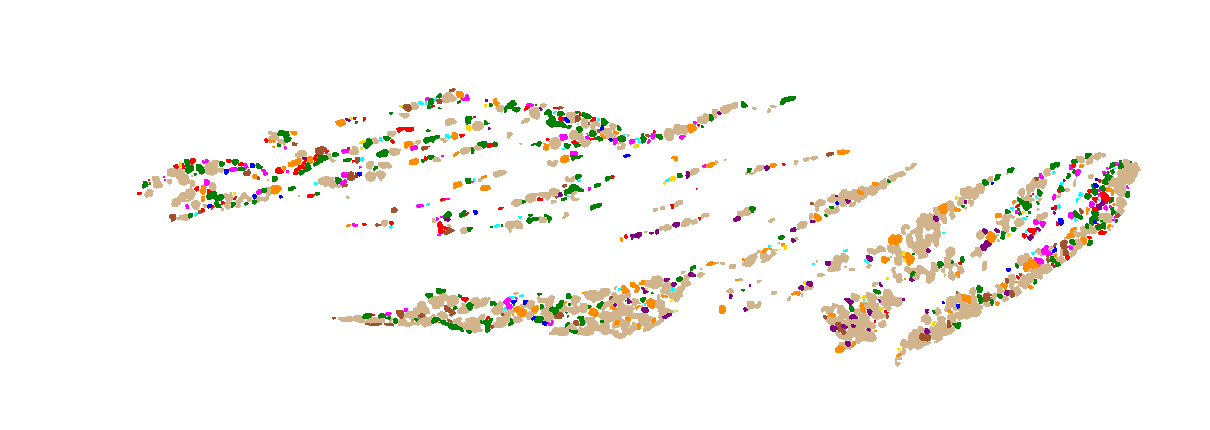

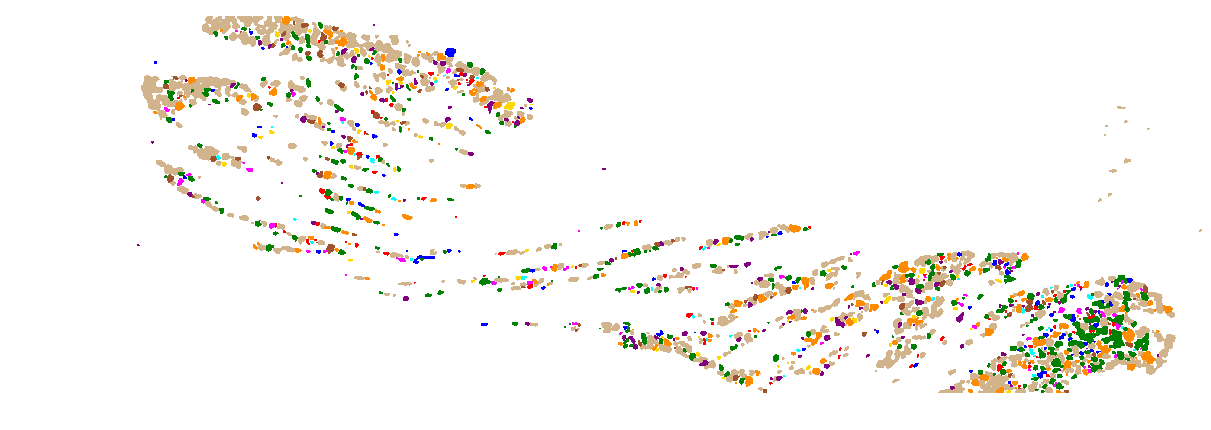

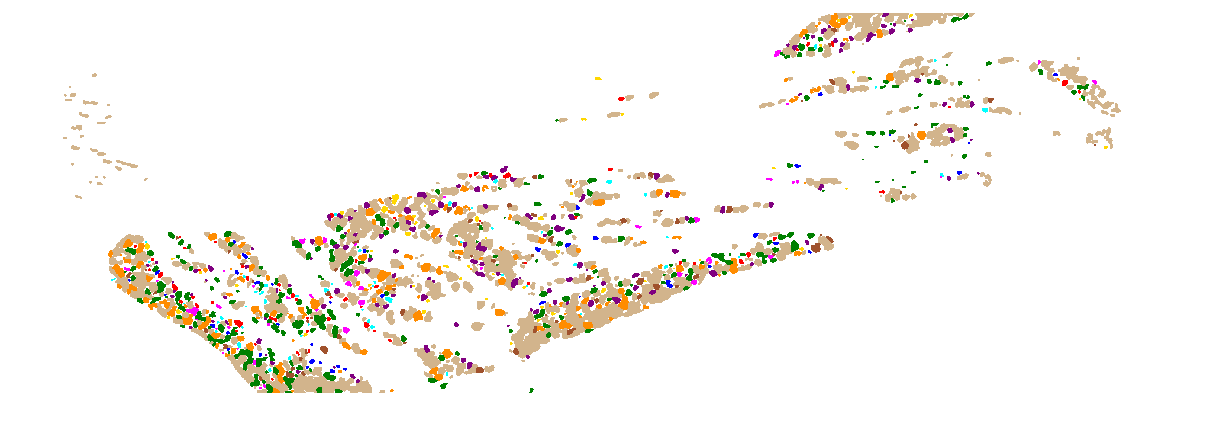

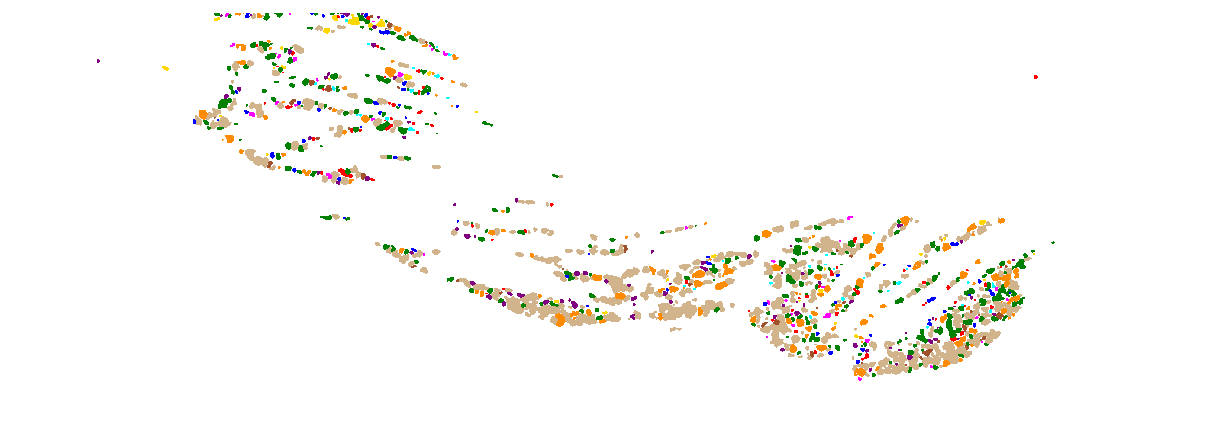

In [40]:
#display colormaps for the discretized predictions
for i,bin_pred in enumerate(bin_preds8):
    colorpred = np.argmax(bin_pred,axis=-1)
    cmap = colors.ListedColormap(COLORLIST)    
    sm = matplotlib.cm.ScalarMappable(cmap=cmap)
    rgb = (sm.to_rgba(colorpred)[:,:,:3]* 255).astype(np.uint8) 
    plt.figure(figsize=(21,7))
    plt.imshow(rgb)
    plt.axis('off')
    
    #save figure if desired
    #imsave(os.path.join(DIR,'images',IMG_NAMES[i] + '-predcolor.tif'),rgb)

## Distance Transform Watershed Segmentation to detect individual cells  
  
In order to segment out individual cells from blobs of partially overlapping cells we perform a distance transform watershed segmentation and store the individual ROIs as OpenCV contours.

In [41]:
def get_contours(pred_bin, kernel = np.ones((2,2))):
    # function performs distance transform watershed segmentation on the individual
    # class layers of a discretized prediction
    
    # returns a list of the openCV contours of the cells and a list of the cell
    # classes (same order)
    contours = []
    classes = []
    
    # we segment each class layer separately
    for class_ in range(1,pred_bin.shape[-1]):
        # get single 2D image of the layer
        opening = pred_bin[:,:,class_]
        # calculate distance transform
        distance = ndi.distance_transform_edt(opening)
        # get local maxima as seeds for watershed
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((8, 8)),
                                    labels=opening)
        # slightly dilate binary cells to give us an outline slightly outside the cells
        dilated = cv2.dilate(opening,kernel,iterations = 1)
        
        # make a label map by watershed segmentation
        markers = ndi.label(local_maxi)[0]
        labels = watershed(-distance, markers, mask=dilated)
        
        # translate labels to openCV contours and add class of cell to class list
        for i in range(1,labels.max()+1):
            _, contour,_ = cv2.findContours((labels == i).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            contours.append(contour[0].astype(int))
            classes.append(class_)
            
    return contours, classes


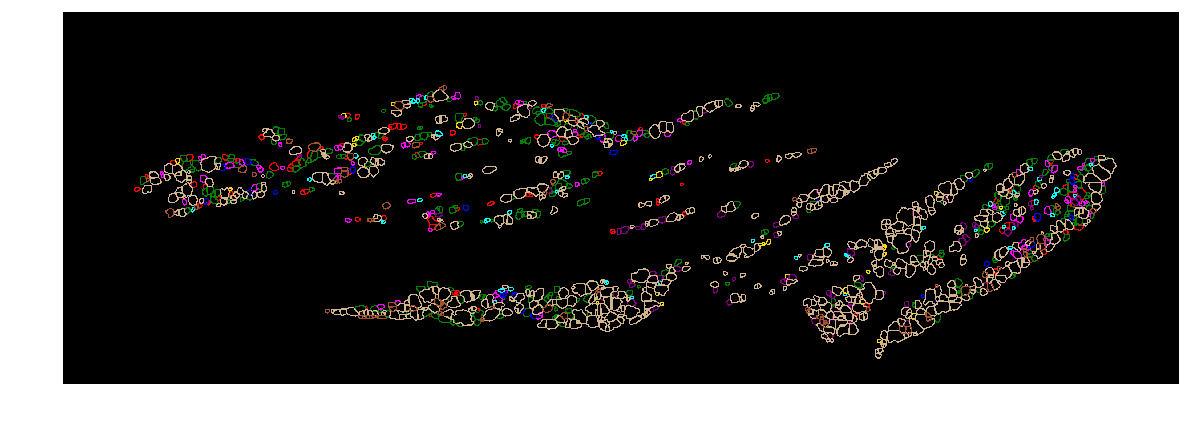

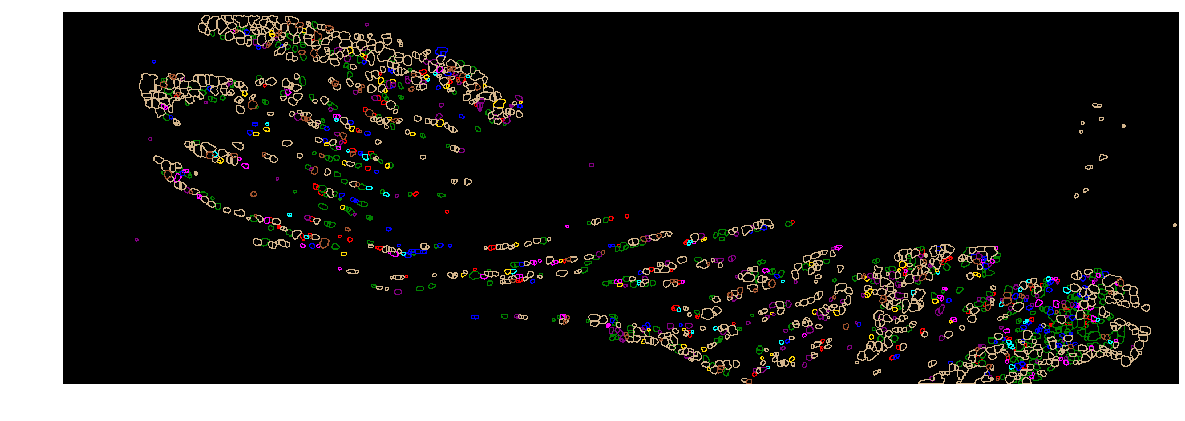

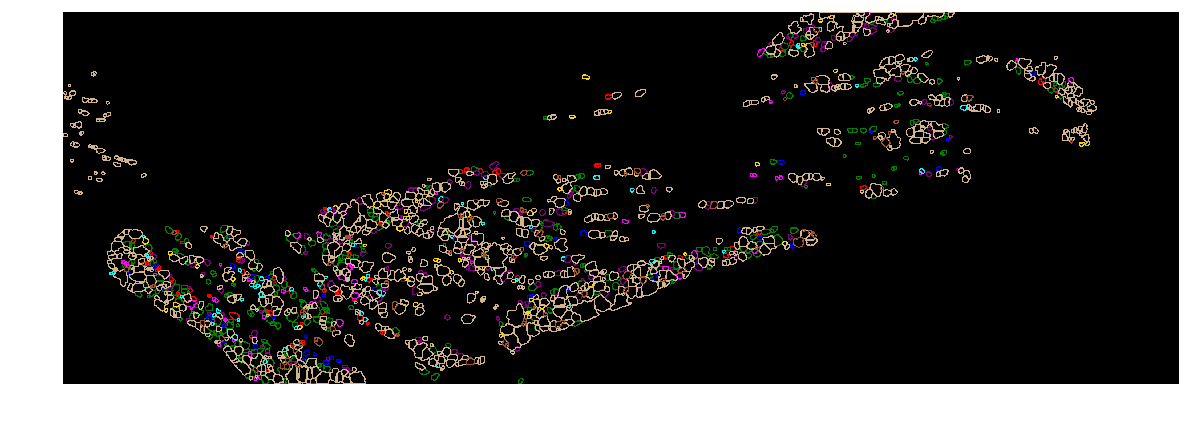

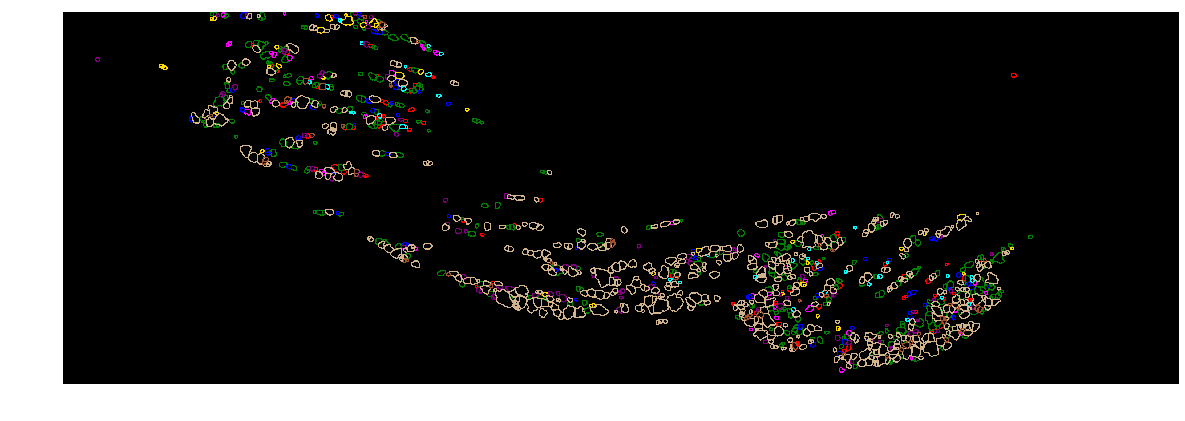

In [46]:
# this is a list of lists (per image) of contours (per cell)
contours = []
# and a corresponding list of lists (per image) of cell class (per cell)
contour_classes = []
# specify dilation kernel for the segmentation function
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],dtype=np.uint8)

# segment all 8 discretized predictions
for bin_pred8 in bin_preds8:
    c, cc = get_contours(bin_pred8,kernel)
    # display contours
    c_img = np.zeros(bin_preds8[i].shape[:-1] + (3,))
    for class_ in range(len(classes_for_UNet)):
        for j in range(len(c)):
            if cc[j] == class_:
                c_img = cv2.drawContours(c_img, c, j, cmap(class_)[:3] , thickness = 2)
    plt.figure(figsize=(20,20))
    plt.imshow(c_img)
    plt.axis('off')
    contours.append(c)
    contour_classes.append(cc)

These OpenCV contours can then be used to extract fluorescence intensities from ISH images.

## Accuracy of the U-Net model

We want to test how precisely the 8 channel models predict the cell class of the manually assigned ROIs.

In [48]:
# get 'ground truth' from the cluster analysis at the top of this notebook
truth = pd.DataFrame({'file':results.filename,'roi':results.index,'class_true':results.UNet})

In [49]:
# function to parse the spreadsheet of probabilities from imageJ
# gets the predicted class (maximum probability if above threshold, otherwise)
# background, for each ROI

def analyze_pred_probs(df):

    # get the mean probability for each ROI out of spreadsheet
    df.columns = [x.lower() for x in df.columns]
    meansframe = df.filter(regex = r'^mean', axis = 1)
    meansframe.index = df.id
    meansframe.columns = [int(str.split(x,"_")[-1])-1 for x in meansframe.columns]
    meansframe = meansframe / 255. #images were 8bit grayscale but we want probability

    # get the maximum probability and class (including or excluding background class)
    meansframe['max1-10'] = meansframe.iloc[:,1:11].max(axis=1)
    meansframe['class1-10'] = meansframe.iloc[:,1:11].idxmax(axis=1)

    # final class and score is from best cell class if probability > 0.1
    # otherwise it is background
    thresh = 0.1
    good_preds = meansframe['max1-10'] > thresh
    meansframe.loc[good_preds,'final_class'] = meansframe.loc[good_preds,'class1-10']
    
    meansframe.loc[~good_preds,'final_class'] = 0
    
    # if the roi was in the rightmost 1/3 (x coordinate > 2048), we add a validation flag
    resultsframe = pd.DataFrame({'roi':df['roi'],'pred_class':meansframe['final_class'],'valid':df.x > 2048})
    return resultsframe

### Evaluation of 8 channel model

We are reading in spreadsheets in which the original ROIs for an ISH image have been used to extract average prediction probabilities for the individual classes

In [51]:
## 8 chan models
filenames = [os.path.join(DIR,'spreadsheets',x) + '_pred8_050218_result.csv' for x in IMG_NAMES ]

pred_frames8 = [None] * len(filenames)
for i,filename in enumerate(filenames):
    ori = pd.read_csv(filename)
    pred_frames8[i] = analyze_pred_probs(ori)
    pred_frames8[i]['file'] = IMG_NAMES[i]

pred_frame8 = pd.concat(pred_frames8,axis=0)


In [52]:
# calculate accuracy on the training and validation set

merged8 = pd.merge(pred_frame8, truth,  how='left', left_on=['file','roi'], right_on = ['file','roi']).fillna(0)
train8 = merged8[~merged8.valid]
valid8 = merged8[merged8.valid]

print("training accuracy: " + str(np.sum(train8.pred_class == train8.class_true)/train8.shape[0]))
print("validation accuracy: " + str(np.sum(valid8.pred_class == valid8.class_true)/valid8.shape[0]))



training accuracy: 0.8544459127808194
validation accuracy: 0.8478884788847888


In [57]:
# generate confusion matrix
cm8 = pd.DataFrame(confusion_matrix(valid8.class_true.astype('uint8').astype('category'),valid8.pred_class.astype('uint8').astype('category')))
# label the axes
cellclasslist = ['background'] + [list(classes_for_UNet.keys())[i] for i in np.argsort(list(classes_for_UNet.values()))]
cm8.index = cellclasslist
cm8.columns = cellclasslist
# re-order the axes
cm8 = cm8.loc[['background','C1','C3','C4','C5','C6','C8','C9','C11','C12','C13'],['background','C1','C3','C4','C5','C6','C8','C9','C11','C12','C13']]
display(cm8)

# save if desired
#cm8.to_csv(os.path.join(DIR,'spreadsheets','confusion_matrix_8chan.csv'))

,background,C1,C3,C4,C5,C6,C8,C9,C11,C12,C13
background,0,0,0,0,0,0,0,0,0,0,0
C1,1,153,0,2,0,1,0,1,1,0,3
C3,7,2,94,6,26,1,0,2,1,2,20
C4,25,2,8,960,11,34,1,2,7,1,5
C5,1,0,13,3,48,0,0,0,0,1,4
C6,0,0,0,20,1,166,0,5,0,1,0
C8,0,0,1,1,0,6,49,9,0,0,1
C9,2,2,1,8,2,32,6,79,1,7,11
C11,0,1,0,8,0,0,0,0,82,2,2
C12,0,0,8,6,0,0,0,2,0,50,14
